<a href="https://colab.research.google.com/github/sarahalayan/CNN_image_classifier/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
#convert Mnist image files into a 4D tensor(number,height,width,color channel)
tranform=transforms.ToTensor()

In [32]:
#train Data
train_data=datasets.MNIST(root='/cnn_data', train=True,download=True,transform=tranform)

In [33]:
#test data
test_data=datasets.MNIST(root='/cnn_data', train=False,download=True,transform=tranform)

In [34]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [35]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [36]:
pwd

'/content'

In [37]:
ls

sample_data/


In [38]:
cd ../

/


In [39]:
ls

bin@       cuda-keyring_1.0-1_all.deb  home/   libx32@                   opt/         run/   tmp/
boot/      datalab/                    lib@    media/                    proc/        sbin@  tools/
cnn_data/  dev/                        lib32@  mnt/                      python-apt/  srv/   usr/
content/   etc/                        lib64@  NGC-DL-CONTAINER-LICENSE  root/        sys/   var/


In [40]:
cd cnn_data/

/cnn_data


In [41]:
ls

MNIST/


In [42]:
cd ../

/


In [43]:
cd content/

/content


DataLoader: This is a PyTorch utility class that helps in creating batches of data for training or evaluation. It is part of the torch.utils.data module.

train_data: This is assumed to be an instance of a PyTorch dataset (e.g., torch.utils.data.Dataset) containing the training samples and their corresponding labels.

batch_size=10: This parameter specifies the number of samples in each batch. In this case, each batch will contain 10 samples.

shuffle=True: This parameter indicates whether the data should be shuffled before each epoch. Shuffling is often done to introduce randomness during training and prevent the model from memorizing the order of the training data.

In [44]:
#create a small batch size for images
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=False)

In [45]:
#define our CNN model
#describe convolutional layer
#we'll have 2 convolutional layers
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)

In [51]:
#Model
class ConvolutionalNetwork(nn.Module):
   def __init__(self):
      super().__init__()
      self.conv1=nn.Conv2d(1,6,3,1) #1 input channel, 6 output channels, a 3x3 kernel, and a stride of 1.
      self.conv2=nn.Conv2d(6,16,3,1)
      #Fully connected layer (after the pooling)
      self.fc1=nn.Linear(5*5*16,120) #5 * 5 * 16 input features and 120 output features.
      self.fc2=nn.Linear(120,84)
      self.fc3=nn.Linear(84,10)#it has to end with 10 bc we have 10 classes

   def forward(self,X):
      X=F.relu(self.conv1(X))
      X=F.max_pool2d(X,2,2) #2 by 2 kernel and a stride of 2
      X=F.relu(self.conv2(X))
      X=F.max_pool2d(X,2,2)
      #flatten our data
      X=X.view(-1,16*5*5)#Flattens the data into a 1D tensor. The size is calculated based on the output size of the last convolutional layer.

      #fully connected layers (usual nn)
      X=F.relu(self.fc1(X))

      X=F.relu(self.fc2(X))
      X=self.fc3(X)
      return F.log_softmax(X,dim=1)#The dim=1 argument indicates that the softmax is applied along the second dimension.


In [52]:
#creating a seed
torch.manual_seed(41)
#create an instance of our model
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [54]:
#criterion and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [55]:
import time
start_time=time.time()
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
for i in range(epochs):
  trn_corr=0
  tst_corr=0

  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(X_train)#not flattened, it is 2d
    loss=criterion(y_pred,y_train)
    predicted=torch.max(y_pred.data,1)[1]

    batch_corr=(predicted==y_train).sum()
    trn_corr +=batch_corr


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if b% 600==0:
      print(f'epoch: {i} Batch:{b} loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val=model(X_test)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr +=(predicted==y_test).sum()

  loss=criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)








current_time=time.time()
total=current_time-start_time
print(f'{total/60} mins')

epoch: 0 Batch:600 loss: 0.01122160442173481
epoch: 0 Batch:1200 loss: 0.5097795128822327
epoch: 0 Batch:1800 loss: 0.27345114946365356
epoch: 0 Batch:2400 loss: 0.5706523656845093
epoch: 0 Batch:3000 loss: 0.010505528189241886
epoch: 0 Batch:3600 loss: 0.1338011920452118
epoch: 0 Batch:4200 loss: 0.0005176571430638433
epoch: 0 Batch:4800 loss: 0.10394303500652313
epoch: 0 Batch:5400 loss: 0.2622598111629486
epoch: 0 Batch:6000 loss: 0.0009407080942764878
epoch: 1 Batch:600 loss: 0.010575367137789726
epoch: 1 Batch:1200 loss: 0.004694225732237101
epoch: 1 Batch:1800 loss: 0.06041830778121948
epoch: 1 Batch:2400 loss: 0.08412185311317444
epoch: 1 Batch:3000 loss: 1.2497214078903198
epoch: 1 Batch:3600 loss: 0.5397676229476929
epoch: 1 Batch:4200 loss: 0.005220157094299793
epoch: 1 Batch:4800 loss: 0.0007686594035476446
epoch: 1 Batch:5400 loss: 0.0005603323224931955
epoch: 1 Batch:6000 loss: 0.08629796653985977
epoch: 2 Batch:600 loss: 0.6476114988327026
epoch: 2 Batch:1200 loss: 0.0078

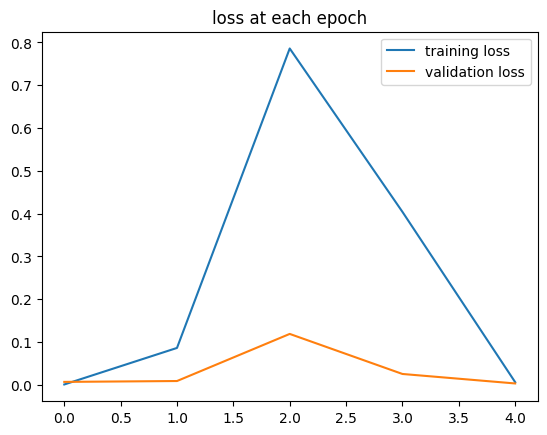

In [60]:
#graph the loss at each epoch
train_losses=[torch.tensor(t) for t in train_losses]
plt.plot(train_losses, label="training loss")
plt.plot(test_losses,label="validation loss")
plt.title("loss at each epoch")
plt.legend()

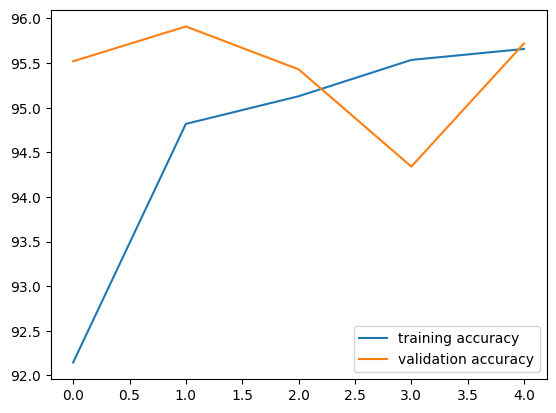

In [61]:
#graph accuracy
plt.plot([t/600 for t in train_correct],label="training accuracy")
plt.plot([t/100 for t in test_correct],label="validation accuracy")
plt.legend()

In [62]:
test_load_everything=DataLoader(test_data, batch_size=10000,shuffle=True)

In [63]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_load_everything:
    y_val=model(X_test)
    predicted=torch.max(y_val,1)[1]
    correct +=(predicted==y_test).sum()

In [65]:
correct.item()/len(test_data) *100

95.72

In [66]:
#grab an image
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

it is 9

In [67]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [68]:
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

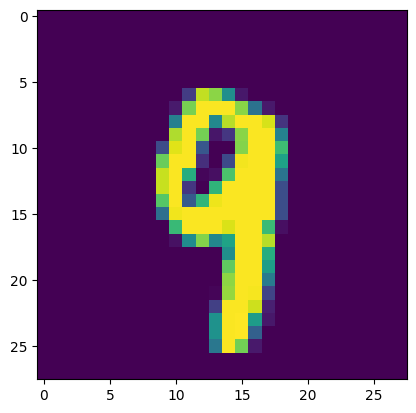

In [69]:
#show the img
plt.imshow(test_data[4143][0].reshape(28,28))

In [70]:
#pass the image to the model
model.eval()
with torch.no_grad():
  new_predict=model(test_data[4143][0].view(1,1,28,28))


In [71]:
new_predict

tensor([[-14.1406, -10.4021, -11.7207,  -9.3655,  -3.4136, -11.3221, -23.4596,
          -6.9363,  -6.9563,  -0.0356]])

In [72]:
#find the biggest one
new_predict.argmax()

tensor(9)

it predicted correctly

In [73]:
#save

In [74]:
torch.save(model.state_dict(), 'CNN_image_classifier.pt')

In [75]:
#load your model
new_model=ConvolutionalNetwork()
new_model.load_state_dict(torch.load('CNN_image_classifier.pt'))

<All keys matched successfully>